### This tutorial demonstrates the multiclass analysis workflow of `BreathPy`.
Initially sample data (MCC-IMS measurements of breath of 7 different mouthwashes, 7 samples each) is downloaded and split into a training and test fraction - the test samples will later serve to validate the created random forest classifier. The samples are normalized and denoised. Afterwards, several peak-detection methods are applied including the `VisualnowLayer` contained in the sample data. Subsequently peaks are aligned using the `ProbeClustering` approach and the features are reduced using `RemovePercentageFeatures` - which limits the reported features to the ones present in at least `percentage_threshold` of the minority class - in this case all mouthwash samples have the same number of samples. 
Features are then weighted using the `PerformanceMeasure`s `RANDOM_FOREST_CLASSIFICATION` and `FDR_CORRECTED_P_VALUE` - leaving 10 features each. 
Two decision trees and a `RandomForestClassifier` are trained. They serve as visual interpretation of the classifcation strategy based on each `PerformanceMeasure`.
After training, the `RandomForestClassifier` is used to predict the class labels of the test samples.
Finally, plots are created and saved in the `results/plots/` directory.

In [1]:
# handle imports
from urllib.request import urlretrieve
from shutil import move as file_move
import numpy as np
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from breathpy.generate_sample_data import generate_train_test_sets, generate_train_test_set_helper
from breathpy.model.BreathCore import (MccImsAnalysis, MccImsMeasurement, PredictionModel,
                              construct_default_parameters,
                              construct_default_processing_evaluation_steps,
                              construct_custom_processing_evaluation_dict)
from breathpy.model.ProcessingMethods import FeatureReductionMethod, PerformanceMeasure, GCMSPeakDetectionMethod, GCMSAlignmentMethod
from breathpy.tools.tools import get_peax_binary_path

from breathpy.view.BreathVisualizations import ClusterPlot, HeatmapPlot, RocCurvePlot, BoxPlot, TreePlot, TimeSeriesPlot

/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# download sample data and split into train and test fraction

url = 'https://github.com/philmaweb/BreathAnalysis.github.io/raw/master/data/mouthwash.zip'
zip_dst = Path("data/mouthwash.zip")
dst_dir = Path("data/mouthwash/")
dst_dir.mkdir(parents=True, exist_ok=True)
urlretrieve(url, zip_dst)

# unzip archive into data subdirectory
with ZipFile(zip_dst, "r") as archive_handle:
    archive_handle.extractall(Path(dst_dir))

raw_dir = dst_dir
target_dir = Path("data/")

# split into train and test fraction - use 1/5 of samples for validation
cross_val_num = 5
generate_train_test_sets(dir_full_set=raw_dir, root_target_dir=target_dir, cross_val_num=cross_val_num, seed=42)

Missing raw files: []
Preparing dataset for Counter({'Rizolöl': 8, 'Mundöl': 8, 'Sandornöl': 8, 'AmphoMoronal': 7, 'Xylocain_Kamille': 7, 'Hexoral': 7, 'Infectosoor': 7}) using 5-fold cross validation splits.
Deleting data/train_mouthwash/ and data/test_mouthwash/
Creating data/train_mouthwash/ and data/test_mouthwash/
||||||||||||||||||||||||||||||||||||||||
Finished preparation of mouthwash



(                       name             label
 0   BD03_1304120923_ims.csv           Rizolöl
 1   BD03_1304120959_ims.csv           Rizolöl
 2   BD03_1304121027_ims.csv           Rizolöl
 3   BD03_1304121230_ims.csv           Rizolöl
 4   BD03_1304121329_ims.csv           Rizolöl
 5   BD03_1304121530_ims.csv           Rizolöl
 6   BD03_1304191053_ims.csv            Mundöl
 7   BD03_1304191200_ims.csv            Mundöl
 8   BD03_1304191304_ims.csv            Mundöl
 9   BD03_1304191401_ims.csv            Mundöl
 10  BD03_1304191500_ims.csv            Mundöl
 11  BD03_1304191700_ims.csv            Mundöl
 12  BD03_1304260929_ims.csv      AmphoMoronal
 13  BD03_1304261006_ims.csv      AmphoMoronal
 14  BD03_1304261054_ims.csv  Xylocain_Kamille
 15  BD03_1304261121_ims.csv      AmphoMoronal
 16  BD03_1304261144_ims.csv  Xylocain_Kamille
 17  BD03_1304261218_ims.csv  Xylocain_Kamille
 18  BD03_1304261232_ims.csv      AmphoMoronal
 19  BD03_1304261314_ims.csv  Xylocain_Kamille
 20  BD03_130

### Now we simplify and go step-by-step through the methods called by `breathpy.model.CoreTest.run_start_to_end_pipeline`

In [3]:
# define default parameters and train / test directory
folder_name = file_prefix = 'train_mouthwash'

plot_parameters, file_parameters = construct_default_parameters(file_prefix, folder_name, make_plots=True)

# create default parameters for preprocessing and evaluation - using 5 fold cross validation
preprocessing_steps, evaluation_params_dict = construct_default_processing_evaluation_steps(cross_val_num)

# define directory for training and test set
train_dir = Path("data/train_mouthwash/")
test_dir = Path("data/test_mouthwash/")

# get class label dict file from training set
train_class_label_dict_fn = MccImsAnalysis.guess_class_label_extension(train_dir)
# print(train_class_label_dict)

# read in raw mcc-ims measurements of training set - based on class_label_dict
train_measurements = [MccImsMeasurement(fn) for fn in train_dir.glob("*ims.csv")]

Parsing Measurement data/train_mouthwash/BD03_1307271429_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307270827_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304261415_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304261218_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304191700_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307261006_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307261200_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304261330_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304191500_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1306291356_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307271129_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304261144_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1304120923_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307261457_ims.csv
Parsing Measurement data/train_mouthwash/BD03_1307261300_ims.csv
Parsing Measurement data/

In [4]:
# setup analysis - need to get path of peax binary and get the visualnowlayer filename
peax_binary_path = get_peax_binary_path()
visualnow_layer_path = [filename for filename in train_dir.glob("*layer*") if
                        (str.endswith(str(filename), "layer.csv") or str.endswith(str(filename), "layer.xls"))][0]

# create output directory
if not Path(file_parameters['out_dir']).exists():
    Path(file_parameters['out_dir']).mkdir(parents=True, exist_ok=True)

# evaluation_params_dict[]    
# create analysis
ims_analysis = MccImsAnalysis(
    train_measurements, preprocessing_steps, outfile_names=[], performance_measure_parameters=evaluation_params_dict,
    class_label_file=train_class_label_dict_fn, dir_level=file_parameters['dir_level'],
    dataset_name=folder_name, visualnow_layer_file=visualnow_layer_path,
    peax_binary_path=peax_binary_path)

# run normalization, denoising and peak_detection for measurements using 6 cores
# for peak_detection we run [PEAX, WATERSHED, VISUALNOWLAYER, TOPHAT] methods defined in preprocessing_steps
# if one want to change default parameters, pass updated parameters for preprocessing_parameters
ims_analysis.preprocess_multicore(num_cores=6)

Applying External Preprocessing with ExternalPeakDetectionMethod.PEAX
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITYApplying Normalization NormalizationMethod.BASELINE_CORRECTION

Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE

Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTERApplying Normalization NormalizationMethod.BASELINE_CORRECTION

Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTIO

Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying denoising Method DenoisingMethod.SAVITZKY_GOLAY_FILTER
Applyi

/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:43: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = skcolor.rgb2gray(df.T.values)
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:532: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:533: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels))


Saving figure to results/plots/heatmapsfast_train_mouthwash_intentsity_plot_BD03_1304120923_ims.png


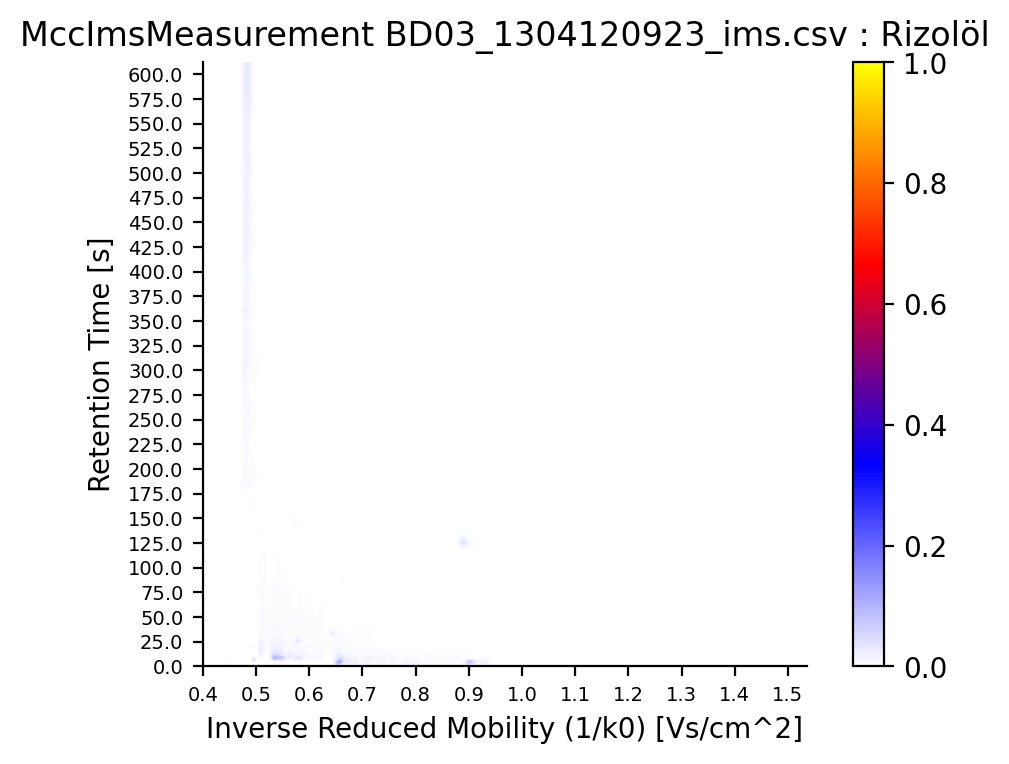

In [5]:
# plot and show a preprocessed measurement
test_measurement = ims_analysis.measurements[0]
HeatmapPlot.FastIntensityMatrix(test_measurement, plot_parameters=plot_parameters, title=str(test_measurement))

Image(Path("results/plots/heatmaps/fast_train_mouthwash_intentsity_plot_BD03_1304120923_ims.png"))

In [6]:
# align peak detection results
ims_analysis.align_peaks()

Applying Peak Alignment PeakAlignmentMethod.PROBE_CLUSTERING
Handling FloatPeakAlignmentResult for _align_peaks_probe_clustering
Applying Probe clustering to dict_keys(['PEAX', 'WATERSHED', 'VISUALNOWLAYER', 'TOPHAT'])


#### Visualize
* show average chromatogram for each candy type - after normalization and denoising
* show clusters for each peak detection method

Plotting Classwise Overlay Plots
class_str=by_class-AmphoMoronal
class_label=AmphoMoronal


/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:43: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = skcolor.rgb2gray(df.T.values)
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:532: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))
/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/view/BreathVisualizations.py:533: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_tick_labels))


class_str=by_class-Hexoral
class_label=Hexoral
class_str=by_class-Infectosoor
class_label=Infectosoor
class_str=by_class-Mundöl
class_label=Mundöl
class_str=by_class-Rizolöl
class_label=Rizolöl
class_str=by_class-Sandornöl
class_label=Sandornöl
class_str=by_class-Xylocain_Kamille
class_label=Xylocain_Kamille


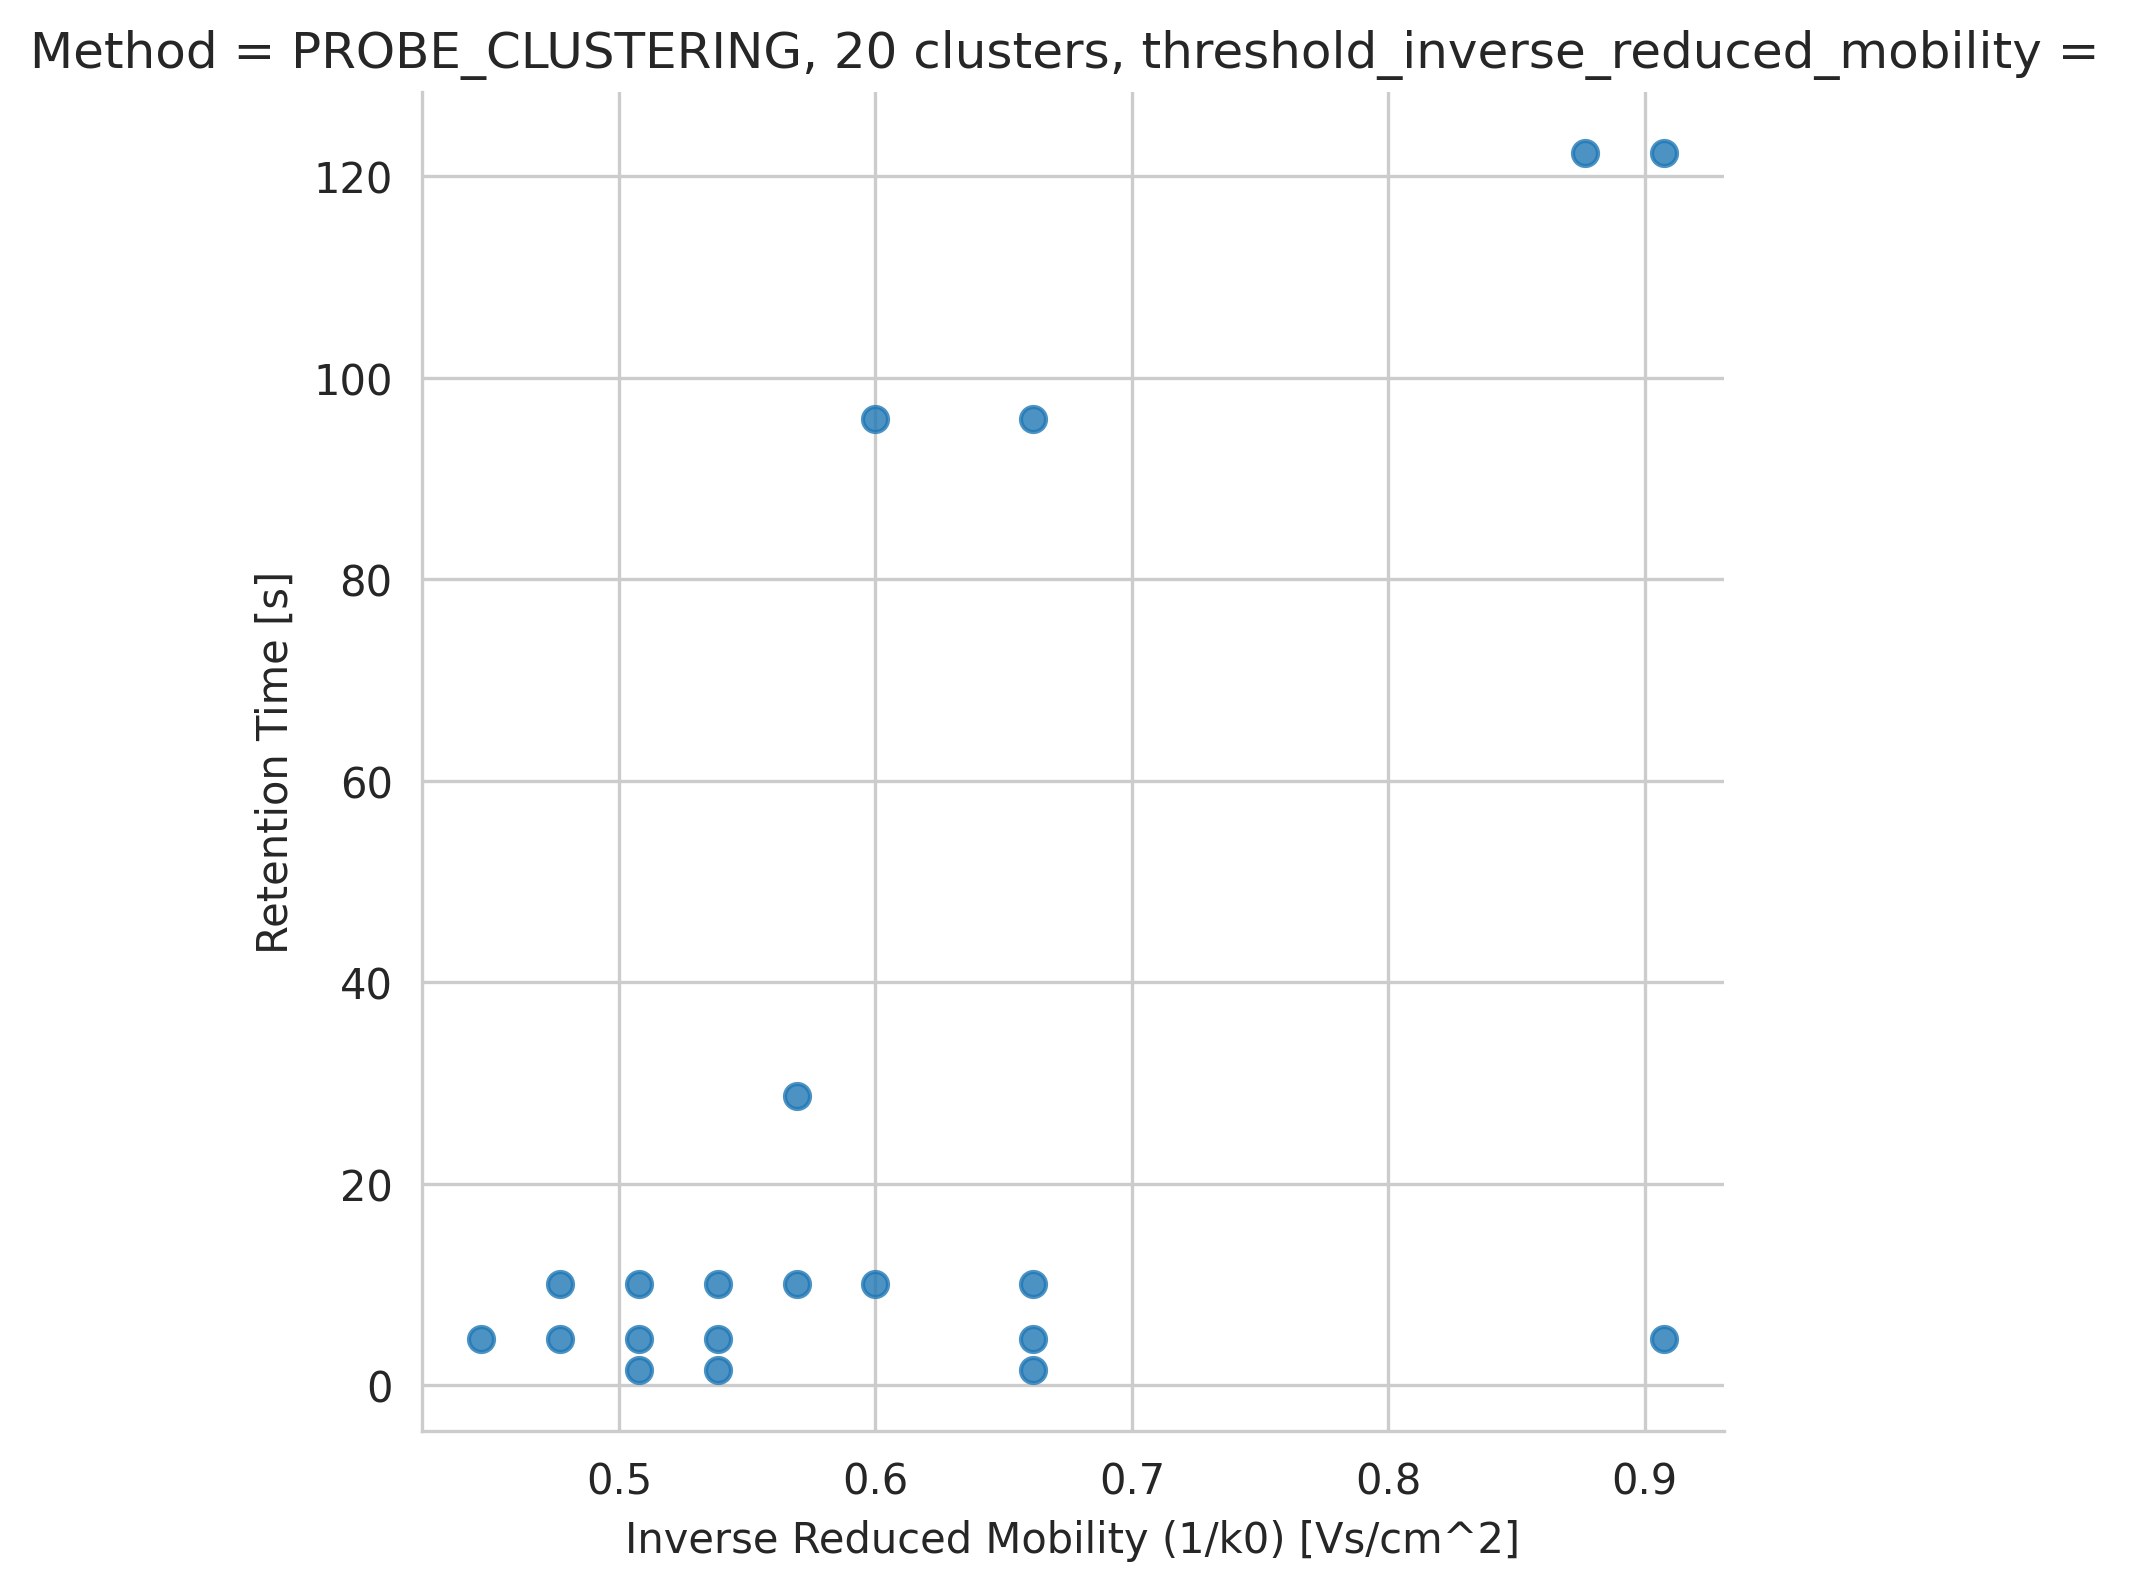

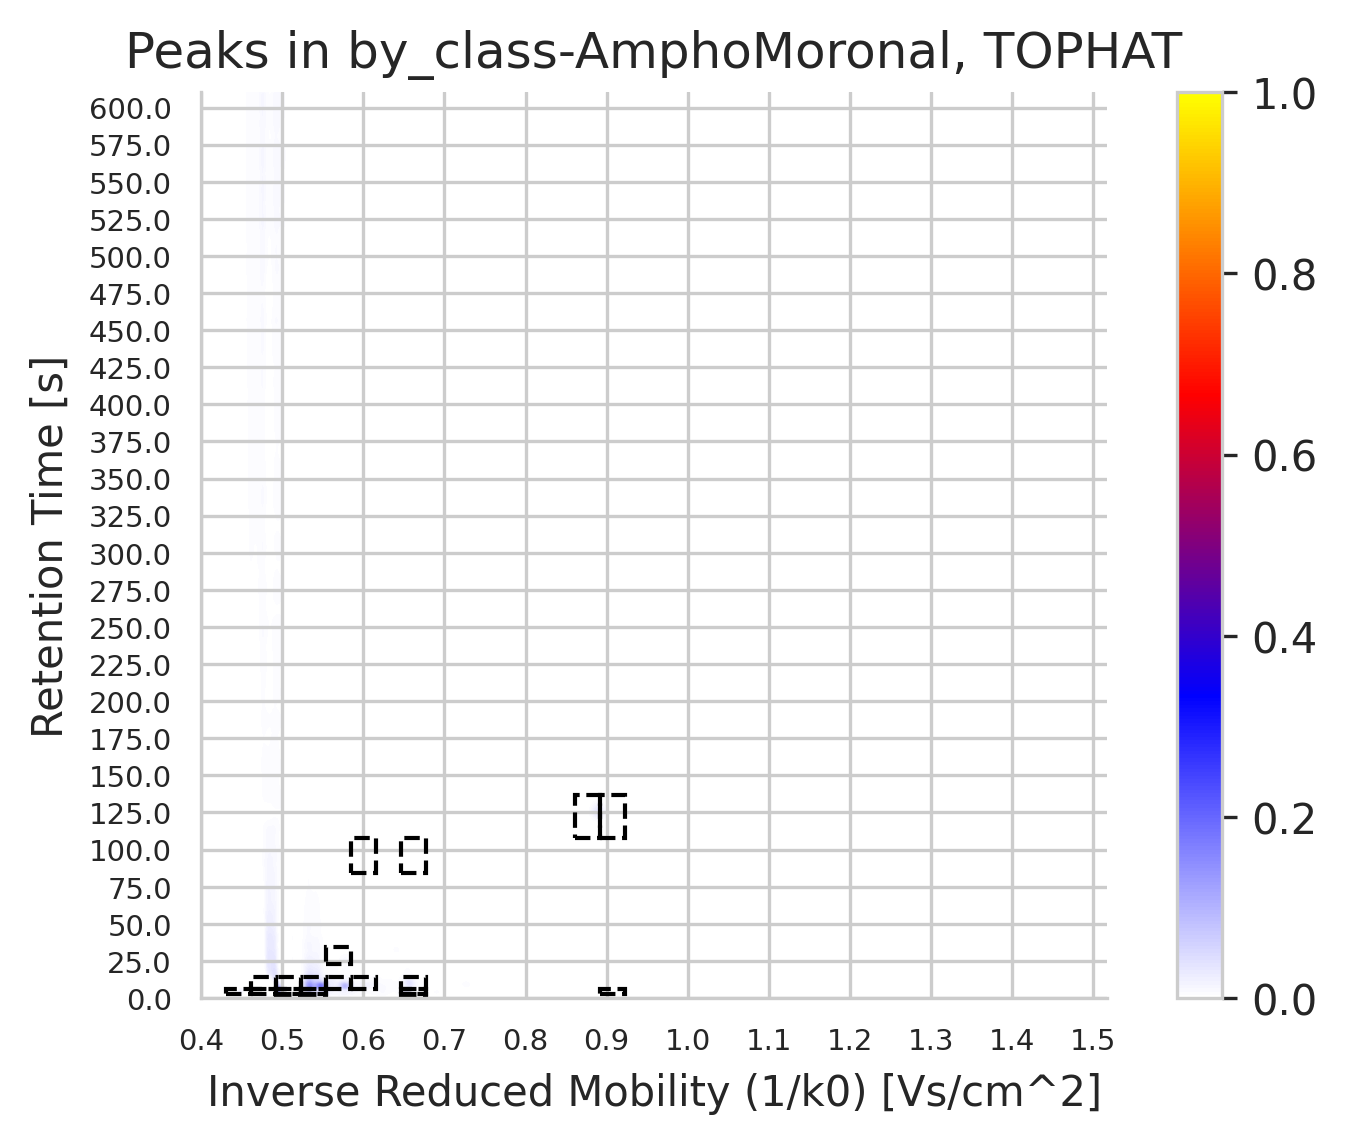

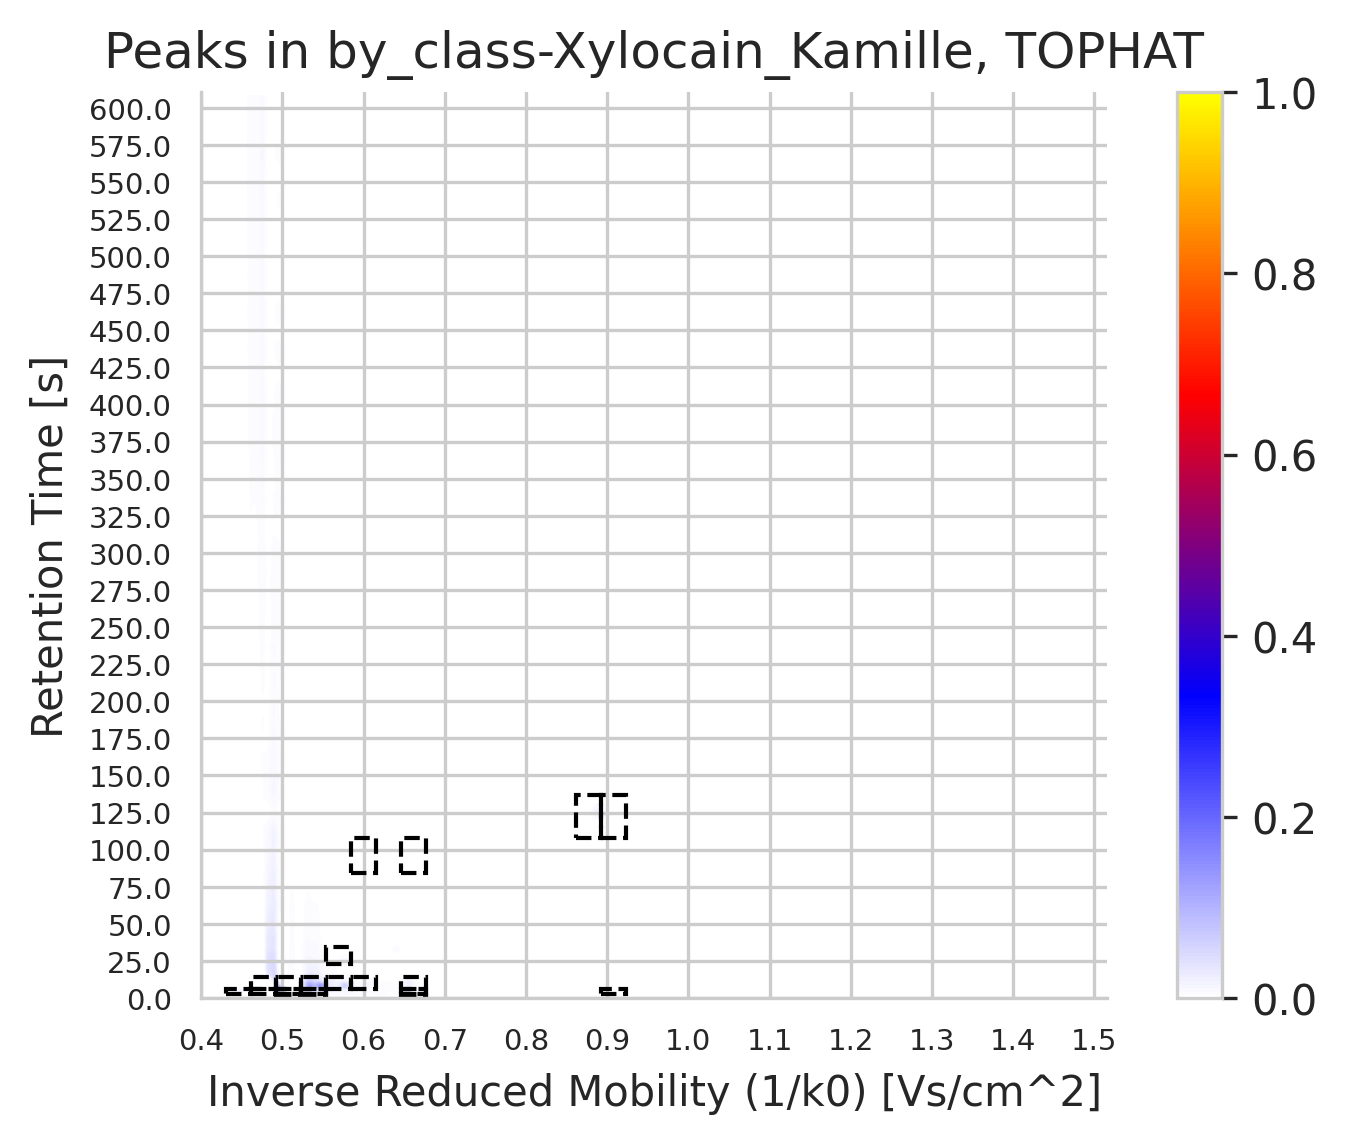

In [7]:
clusters = ClusterPlot.ClusterBasic(ims_analysis, plot_parameters=plot_parameters)
overlays = ClusterPlot.OverlayClasswiseAlignment(ims_analysis, plot_parameters=plot_parameters)

# get paths of the images
cluster_fn = Path(clusters[2][-1])
overlay_fn_amph =Path("results/plots/overlay/")/overlays[2][-1]
overlay_fn_xylo =Path("results/plots/overlay/")/overlays[-2][-1]

# display images for the TOPHAT method
images = [cluster_fn, overlay_fn_amph, overlay_fn_xylo]

for fn in images:
    display(Image(fn))

In [8]:
# apply feature reduction
ims_analysis.reduce_features(ims_analysis.AVAILABLE_FEATURE_REDUCTION_METHODS)
# evaluate model performance using 5-fold cross-validation
ims_analysis.evaluate_performance()

Applying feature reduction with {RANDOM_FOREST_CLASSIFICATION: {'n_splits_cross_validation': 5, 'n_estimators_random_forest': 2000, 'n_of_features': 10}, FDR_CORRECTED_P_VALUE: {'benjamini_hochberg_alpha': 0.05, 'n_of_features': 10, 'n_splits_cross_validation': 5}, DECISION_TREE_TRAINING: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}, REMOVE_PERCENTAGE_FEATURES: {'noise_threshold': 0.0001, 'percentage_threshold': 0.5}}
Reduced WATERSHED AlignmentResult from 6394 to 380 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced VISUALNOWLAYER AlignmentResult from 2788 to 68 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced TOPHAT AlignmentResult from 228 to 10 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Reduced PEAX AlignmentResult from 796 to 39 features by applying noise_threshold 0.0001 and percentage_threshold 0.5
Applying performance measure PerformanceMeasure.RANDOM_FOREST_CLASSIFIC

/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/model/BreathCore.py:5278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvals_current_class['1-corrected_p_values'] = 1 - pvals_current_class.loc[:, 'corrected_p_values']


The VISUALNOWLAYER-method was applied as peak detection. 

The statistics of the evaluation are: 
Precision: 0.41786 +- (0.07828)
Recall: 0.37142857142857144 +- (0.11428571428571428)
Roc_AUC: 0.9667942176870747 +- (0.01497)
Accuracy: 0.29444 +- (0.10334)
F1-Score: 0.33809523809523806 +- (0.09331389496316869)



/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/model/BreathCore.py:5278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvals_current_class['1-corrected_p_values'] = 1 - pvals_current_class.loc[:, 'corrected_p_values']


The TOPHAT-method was applied as peak detection. 

The statistics of the evaluation are: 
Precision: 0.26468 +- (0.03909)
Recall: 0.14285714285714285 +- (0.04517539514526256)
Roc_AUC: 0.8241496598639456 +- (0.03312)
Accuracy: 0.14722 +- (0.05167)
F1-Score: 0.15238095238095237 +- (0.046656947481584346)



/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/model/BreathCore.py:5278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvals_current_class['1-corrected_p_values'] = 1 - pvals_current_class.loc[:, 'corrected_p_values']


The PEAX-method was applied as peak detection. 

The statistics of the evaluation are: 
Precision: 0.54921 +- (0.14396)
Recall: 0.5142857142857142 +- (0.17728105208558367)
Roc_AUC: 0.9650935374149661 +- (0.01146)
Accuracy: 0.46667 +- (0.15230)
F1-Score: 0.49904761904761896 +- (0.16414141350712777)



/home/pweber/anaconda3/envs/breath/lib/python3.8/site-packages/breathpy/model/BreathCore.py:5278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvals_current_class['1-corrected_p_values'] = 1 - pvals_current_class.loc[:, 'corrected_p_values']


Applying performance measure PerformanceMeasure.FDR_CORRECTED_P_VALUE with {'benjamini_hochberg_alpha': 0.05, 'n_of_features': 10, 'n_splits_cross_validation': 5}
Applying performance measure PerformanceMeasure.DECISION_TREE_TRAINING with {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training decision trees with {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [9]:
# export preprocessed files, peak detection results and feature_matrixes to csv into results directory
print(file_parameters['out_dir'])

# export preprocessed files, peak detection results and feature_matrixes to csv into results directory
ims_analysis.export_results_to_csv(file_parameters['out_dir'])

results/data/train_mouthwash/
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304120923_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304120959_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304121027_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304121230_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304121329_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304121530_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304191053_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304191200_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwash/BD03_1304191304_ims_preprocessed.csv
Saving preprocessed measurement to results/data/train_mouthwa

#### Visualize the analysis:
* show estimated model performance - ROC curve
* show best features superimposed for each candy type
* plot boxplot and time-series plot for each feature


Plotting multiclass ROC curve
Plotting Boxplots of the best features SEABORN
Plotting Decision trees buffer = False for AnalysisResult of dataset 'train_mouthwash' with [WATERSHED, VISUALNOWLAYER, TOPHAT, PEAX] PeakAlignmentMethod.PROBE_CLUSTERING for 41 measurements


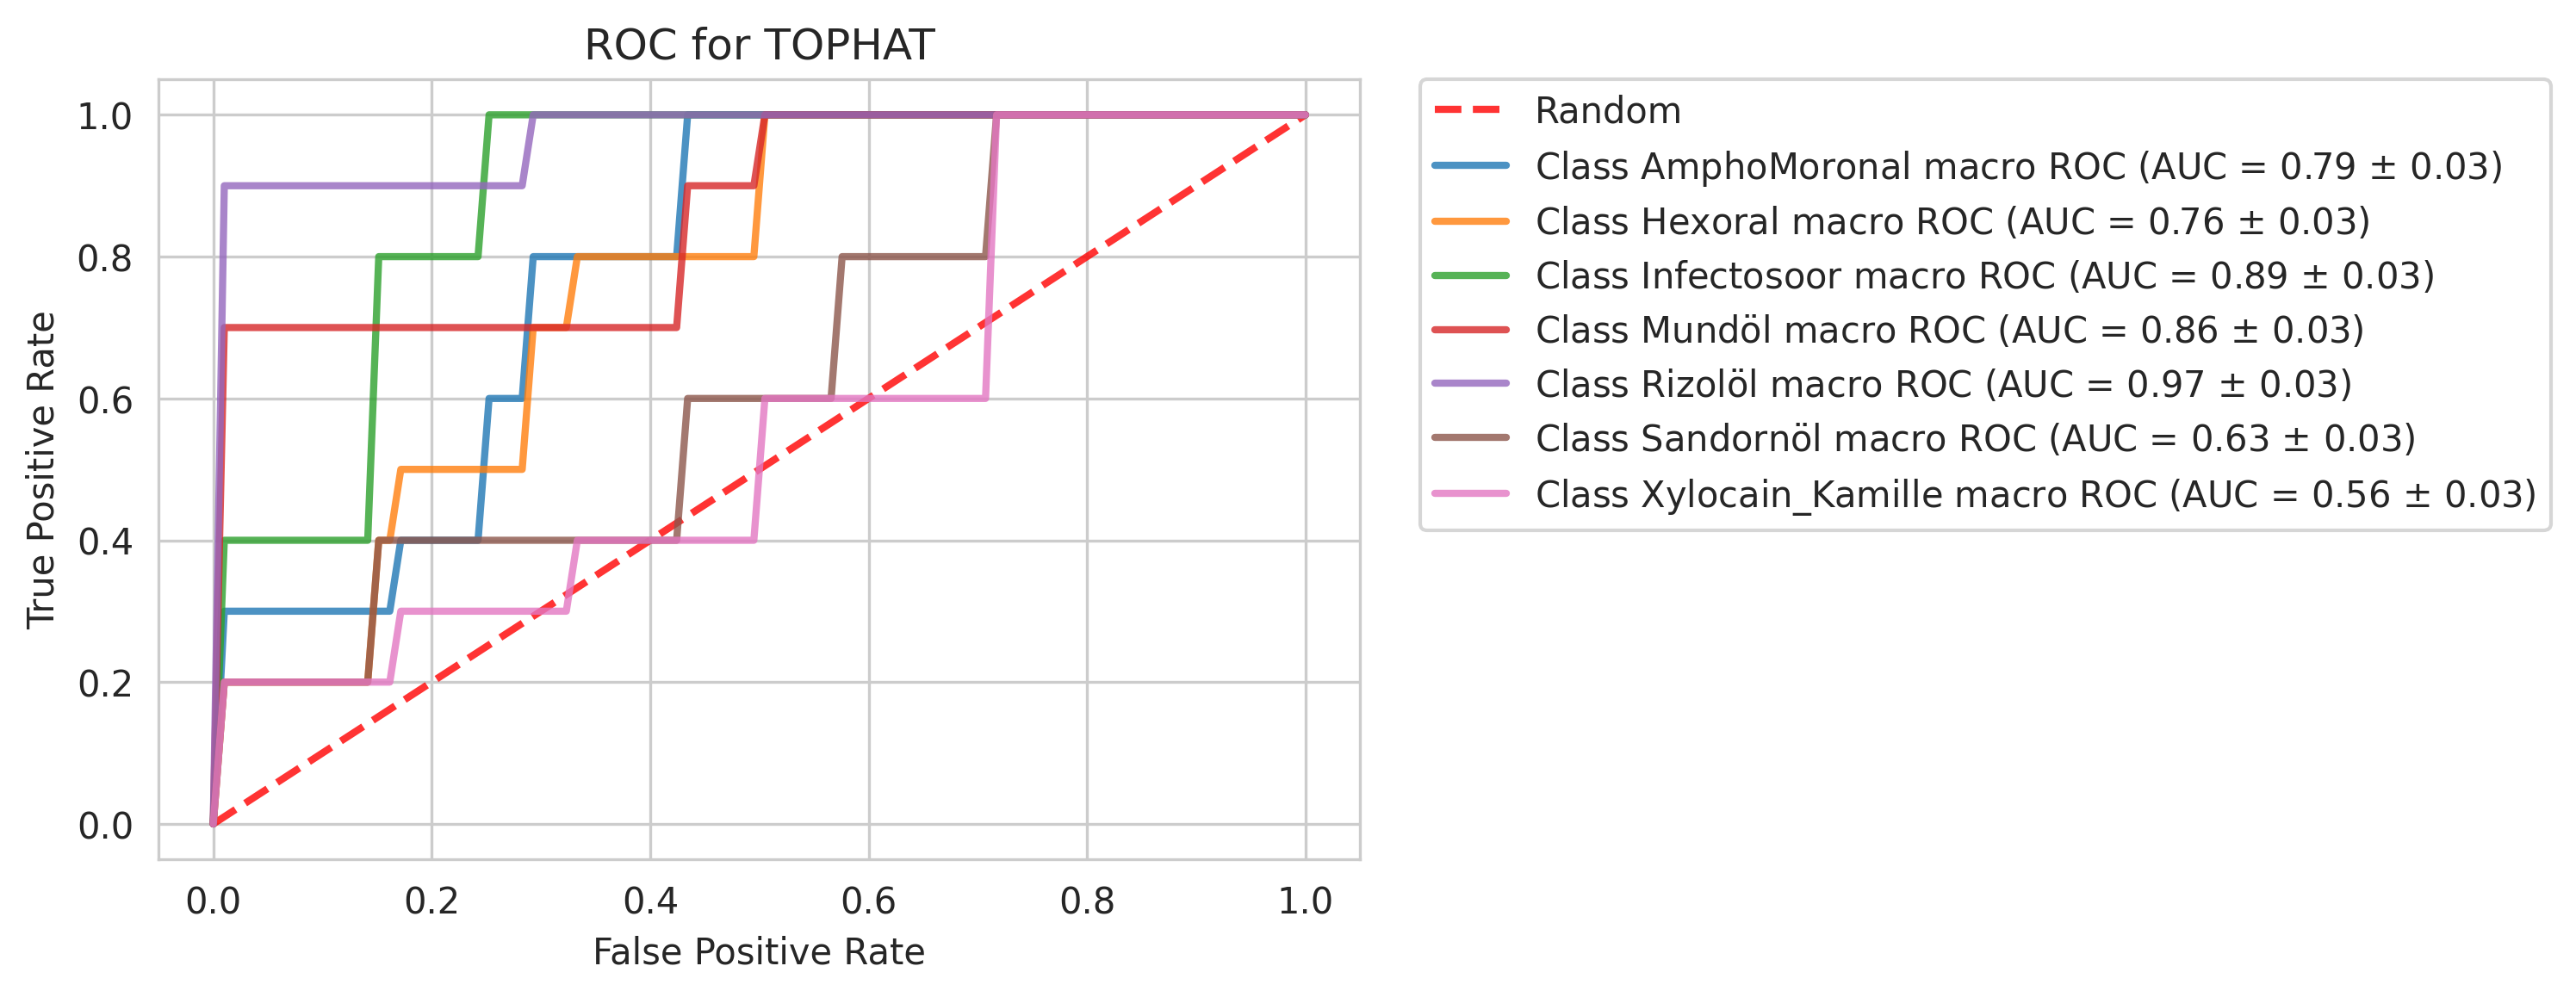

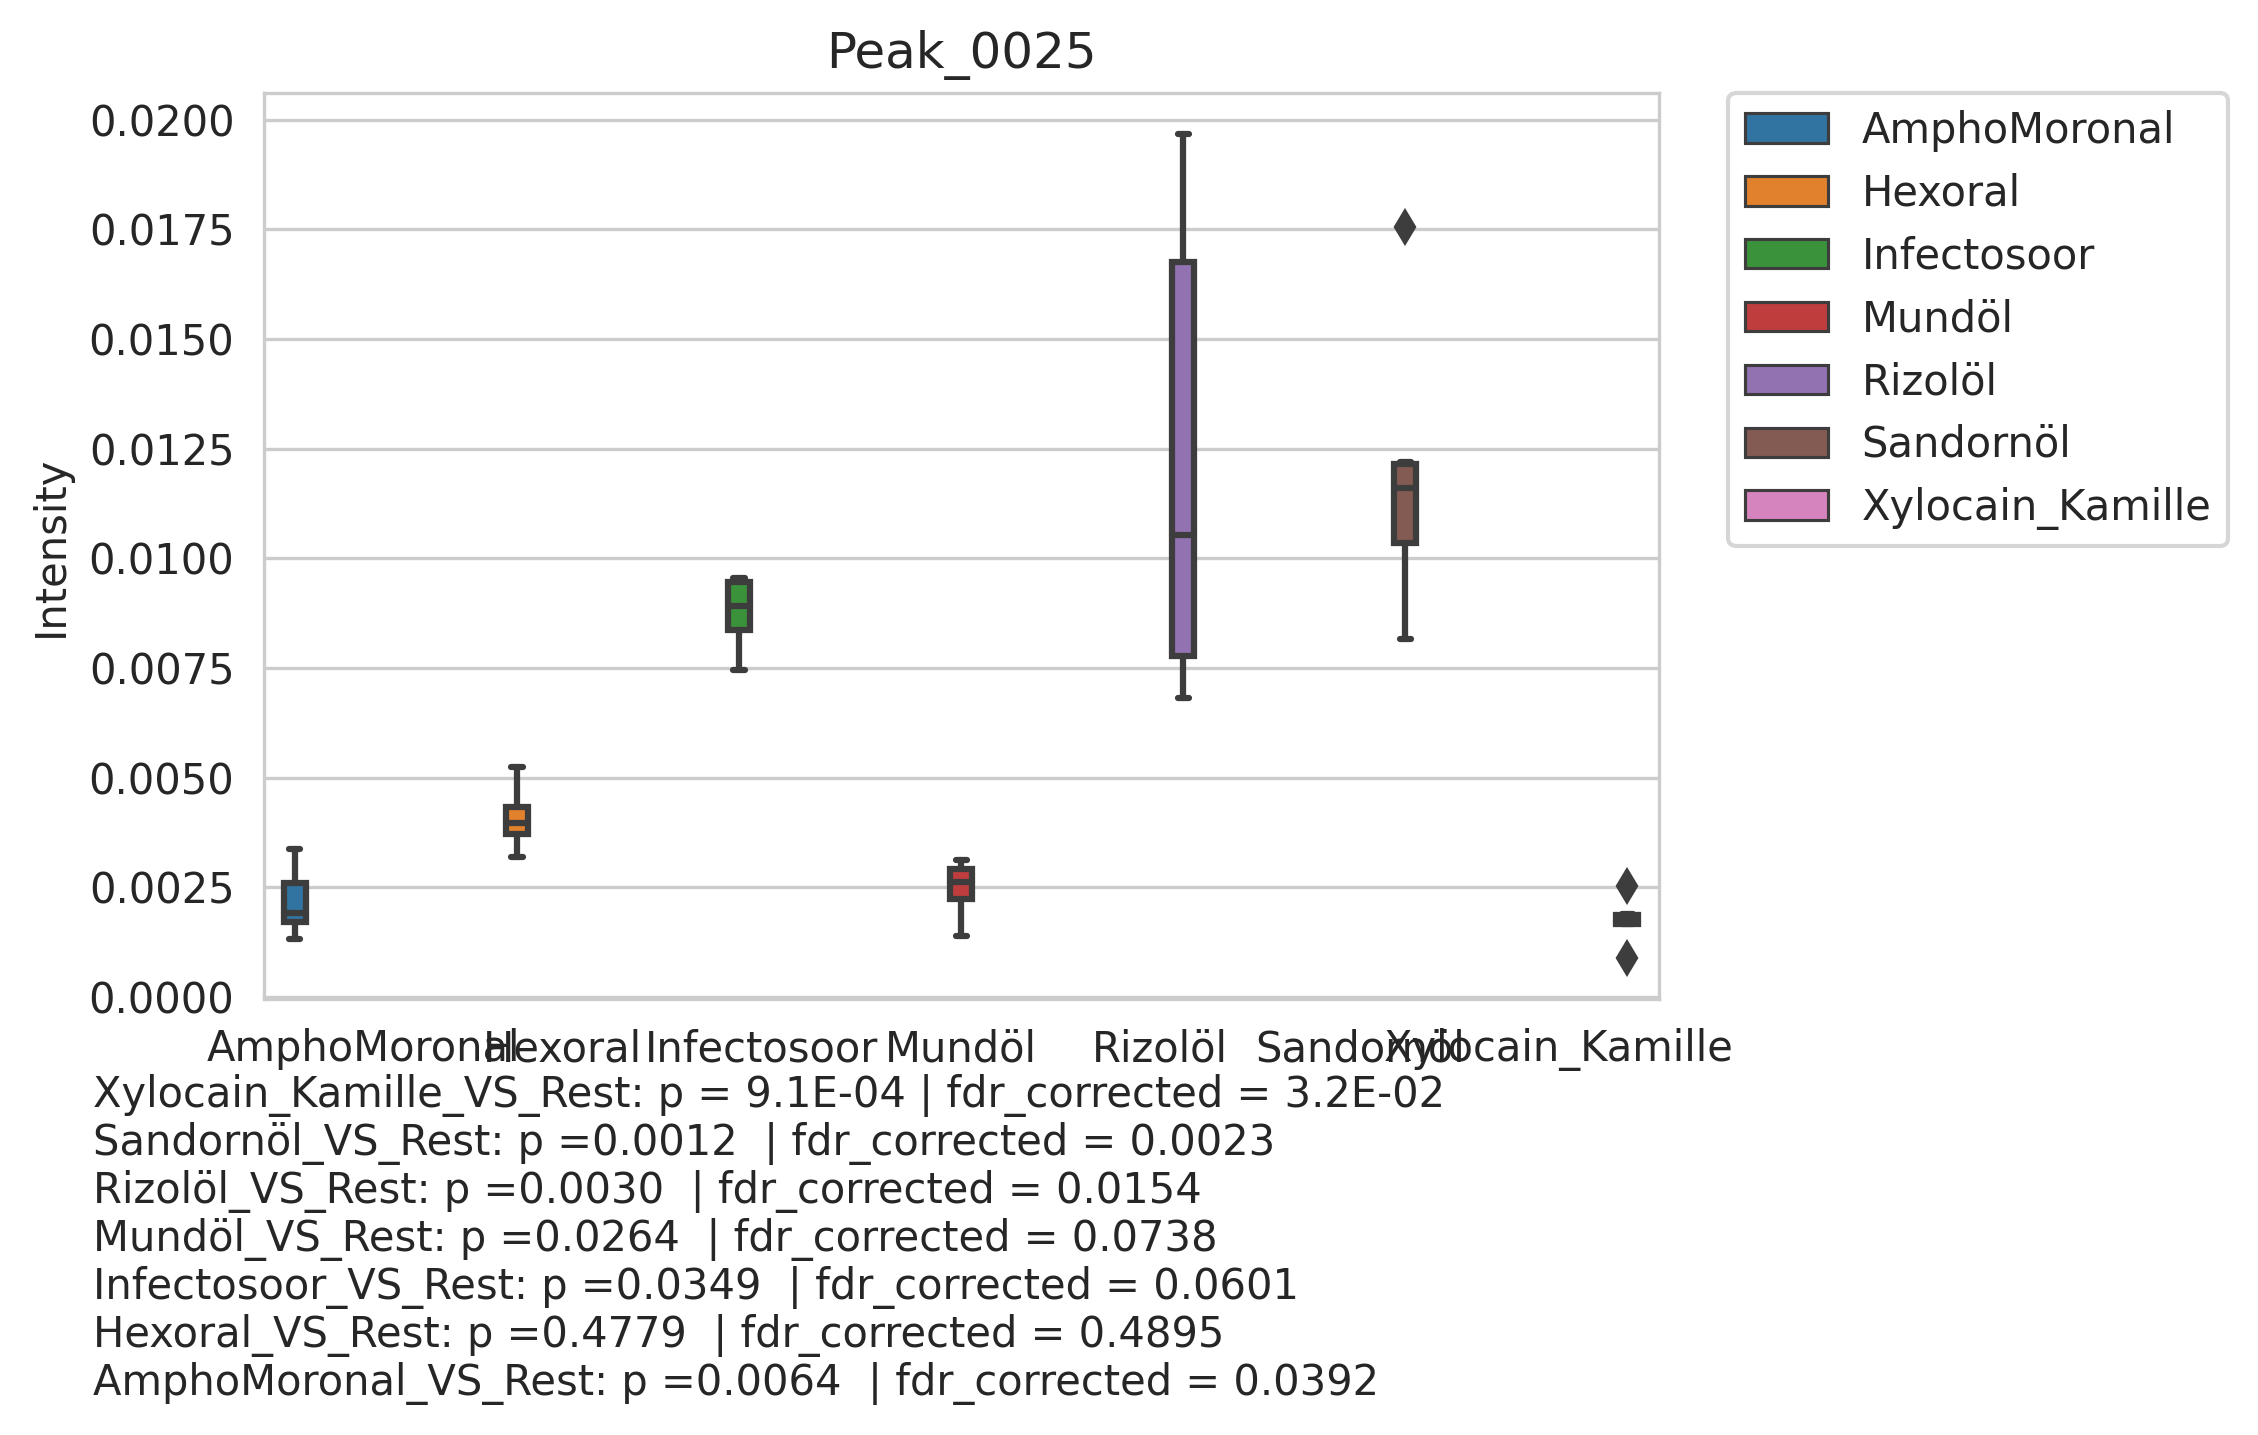

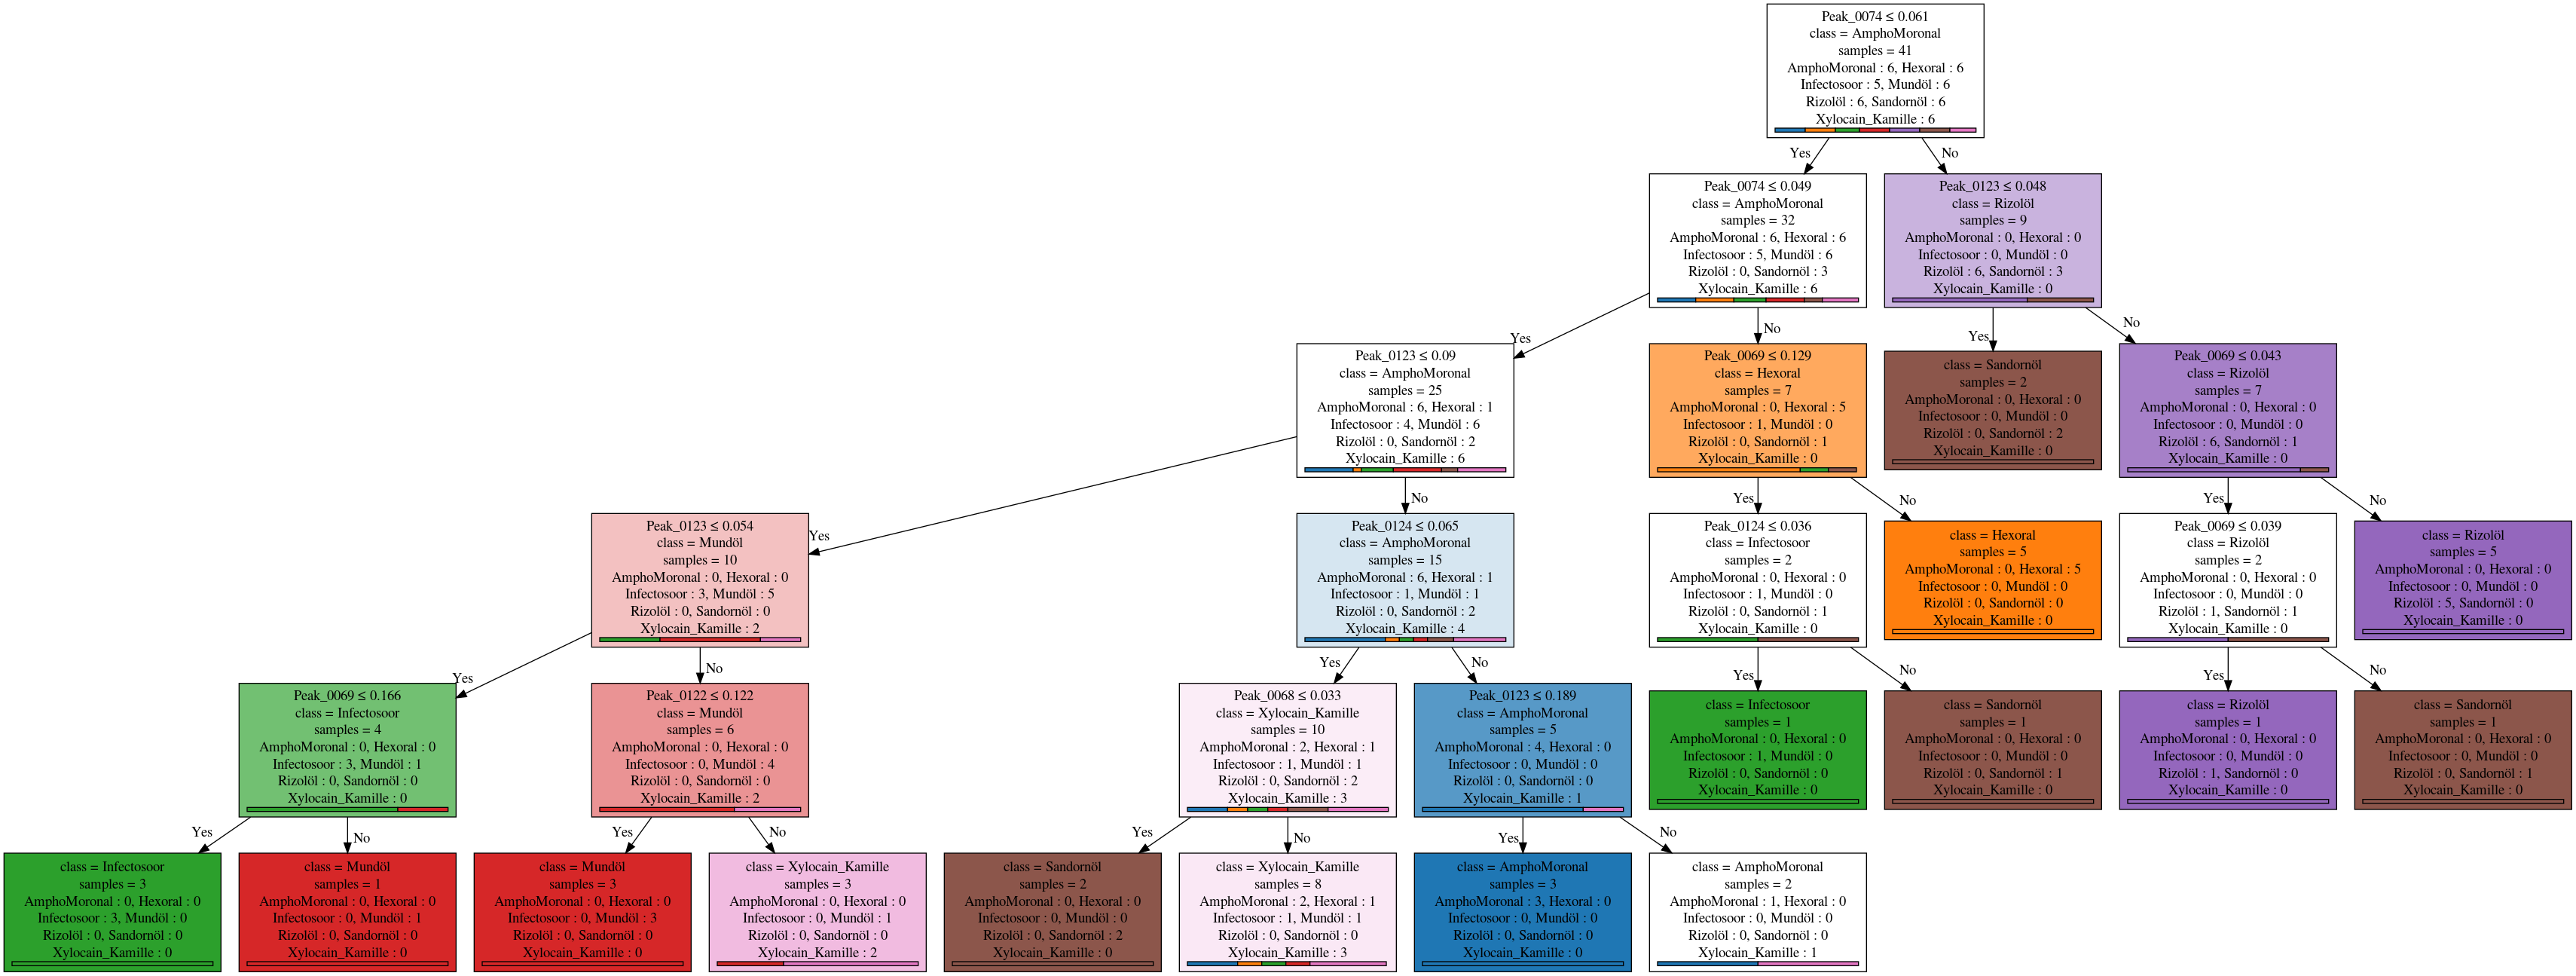

In [10]:
roc_plots = RocCurvePlot.MultiClassROCCurve(ims_analysis.analysis_result, plot_parameters=plot_parameters)
box_plots = BoxPlot.BoxPlotBestFeature(ims_analysis.analysis_result, plot_parameters=plot_parameters)

try:
    dt_plots = TreePlot.DecisionTrees(ims_analysis.analysis_result, plot_parameters=plot_parameters, limit_to_peak_detection_method_name="TOPHAT")
except FileNotFoundError as e:
    # might not both be installed - need system executable and python library
    print("Probably graphviz is not installed - install via `conda install graphviz python-graphviz`")
    raise(e)

roc_fn = roc_plots[2][-1]
box_plot_fn = box_plots[0][-1]
if dt_plots:
    dt_fn = Path(dt_plots[1][-1][-1])

# display images for the TOPHAT method
images = [roc_fn, box_plot_fn, dt_fn]

for fn in images:
    display(Image(fn))

In [11]:
# prediction

# export prediction model and import from pickle
predictor_path = Path(file_parameters['out_dir'])/"predictors.sav"
ims_analysis.analysis_result.export_prediction_models(path_to_save=predictor_path)
predictors = joblib.load(predictor_path)

predictionModel = PredictionModel(ims_analysis)

#  preparation - replace train_ with test_
#  otherwise can't find measurements - as the class labels don't match the measurement names
file_parameters['folder_path'] = file_parameters['folder_path'].replace("train_", "test_")
test_dir = file_parameters['folder_path']

test_result_dir = file_parameters['out_dir'].replace("train_", "test_")

test_measurements_fns = sorted(Path(test_dir).glob("*ims.csv"))
test_measurements = [MccImsMeasurement(fn) for fn in test_measurements_fns]

Parsing Measurement data/test_mouthwash/BD03_1304121059_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1304121133_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1304191130_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1304191230_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1304260941_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1304261030_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1306291755_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1307260928_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1307261030_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1307271003_ims.csv
Parsing Measurement data/test_mouthwash/BD03_1307271229_ims.csv


In [12]:
# predict - and run full preprocessing and alignment on test_measurements
prediction = predictionModel.predict(test_measurements)

Applying External Preprocessing with ExternalPeakDetectionMethod.PEAX
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.SAVITZKY_GOLAY_FILTER
Applying denoising Method DenoisingMethod.MEDIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization NormalizationMethod.INTENSITY_NORMALIZATION
Applying Normalization NormalizationMethod.BASELINE_CORRECTION
Applying denoising Method DenoisingMethod.CROP_INVERSE_REDUCED_MOBILITY
Applying denoising Method DenoisingMethod.DISCRETE_WAVELET_TRANSFORMATION
Applying denoising Method DenoisingMethod.SAVITZKY_GOLAY_FILTER
Applying denoising Method DenoisingMethod.MEDIAN_FILTER
Applying denoising Method DenoisingMethod.GAUSSIAN_FILTER
Applying Normalization

In [13]:
test_labels_dict_fn = MccImsAnalysis.guess_class_label_extension(test_dir)
test_labels_dict = MccImsAnalysis.parse_class_labels(test_labels_dict_fn)
class_labels = np.unique([m.class_label for m in ims_analysis.measurements])
test_measurements_names = [path.name for path in test_measurements_fns]
for pdm, prediction_index in prediction.items():
    predicted_labels = {test_name: class_labels[p] for p, test_name in zip(prediction_index, test_measurements_names)}
    correct = dict()
    false = dict()
    for fn, predicted_label in predicted_labels.items():
        if predicted_label == test_labels_dict[fn]:
            correct[fn] = predicted_label
        else:
            false[fn] = predicted_label

    print(f"resulting_labels for {pdm.name} are: {predicted_labels}")
    print(f"Falsely classified: {false}\n")
    print(f"That's {len(correct.keys())} correct vs {len(false.keys())} false\n")

resulting_labels for WATERSHED are: {'BD03_1304121059_ims.csv': 'Rizolöl', 'BD03_1304121133_ims.csv': 'Rizolöl', 'BD03_1304191130_ims.csv': 'Mundöl', 'BD03_1304191230_ims.csv': 'Hexoral', 'BD03_1304260941_ims.csv': 'AmphoMoronal', 'BD03_1304261030_ims.csv': 'AmphoMoronal', 'BD03_1306291755_ims.csv': 'AmphoMoronal', 'BD03_1307260928_ims.csv': 'Sandornöl', 'BD03_1307261030_ims.csv': 'Sandornöl', 'BD03_1307271003_ims.csv': 'Infectosoor', 'BD03_1307271229_ims.csv': 'Infectosoor'}
Falsely classified: {'BD03_1304191230_ims.csv': 'Hexoral', 'BD03_1304260941_ims.csv': 'AmphoMoronal', 'BD03_1306291755_ims.csv': 'AmphoMoronal'}

That's 8 correct vs 3 false

resulting_labels for VISUALNOWLAYER are: {'BD03_1304121059_ims.csv': 'Rizolöl', 'BD03_1304121133_ims.csv': 'Rizolöl', 'BD03_1304191130_ims.csv': 'Mundöl', 'BD03_1304191230_ims.csv': 'Mundöl', 'BD03_1304260941_ims.csv': 'AmphoMoronal', 'BD03_1304261030_ims.csv': 'AmphoMoronal', 'BD03_1306291755_ims.csv': 'Mundöl', 'BD03_1307260928_ims.csv': 'S